# Проверка гипотез для увеличения выручки интернет-магазина

**Цель исследования** \
Проранжировать гипотезы для увеличения выручки интернет-магазина с помощью фреймворков ICE и RICE и провести А/В тест


**Описание данных** \
Анализ проводится на основе трех датасетов с информацией о гипотезах, заказах и посетителях сайта в период проведения A/B теста

**План работы**

*Часть 1. Приоритизация гипотез*
- Приоритизировать гипотезы с помощью фреймворков ICE и RICE

*Часть 2. Анализ A/B-теста*
- Построить график кумулятивной выручки по группам
- Построить графики кумулятивного среднего чека по группам и относительного изменения кумулятивного среднего чека группы B к группе A
- Построить графики кумулятивного среднего количества заказов на посетителя по группам и относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A
- Построить точечный график количества заказов по пользователям и посчитать 95-й и 99-й перцентили количества заказов на пользователя для определения аномальных пользователей
- Построить точечный график стоимостей заказов и посчитать 95-й и 99-й перцентили стоимости заказов для определения границы аномальных заказов
- Рассчитать статистическую значимость различий в среднем количестве заказов на посетителя и статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным
- Рассчитать статистическую значимость различий в среднем количестве заказов на посетителя и статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным 
- Принять решение по результатам теста и обосновать его

## Часть 1. Приоритизация гипотез

In [1]:
#Загружаем необходимые библиотеки
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 100)

In [2]:
# Читаем CSV-файл с данными
data = pd.read_csv('hypothesis_data.csv')
data

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [3]:
# Изучаем информацию о таблице
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
# Приведем названия столбцов к нижнему регистру 
data.columns = ['hypothesis', 'reach', 'impact', 'confidence', 'efforts']
data

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


**Промежуточный вывод:** Датафрейм содержит информацию о гипотезах по увеличению выручки интернет-магазина с заданными параметрами (9 записей). Первичное знакомство с данными говорит об их высоком качестве: отсутствуют пропуски и корректно определен тип данных, однако потребовалось приведение названий столбцов к нижнему регистру.

In [5]:
#Рассчитываем ICE для каждой гипотезы и результат сохраняем в столбце ICE
data['ICE'] = data['impact'] * data['confidence'] / data['efforts']

# Выводим столбцы 'hypothesis' и 'ICE', отсортированные по столбцу 'ICE'
data[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False).round(2)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


In [6]:
#Рассчитываем RICE для каждой гипотезы и результат сохраняем в столбце RICE
data['RICE'] = data['reach']*data['impact']*data['confidence'] / data['efforts']

# Выводим столбцы 'hypothesis' и 'RICE', отсортированные по столбцу 'RICE'
data[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False).round(2)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


**Вывод:** 

Наиболее перспективные гипотезы по ICE: \
(8)  Запустить акцию, дающую скидку на товар в день рождения \
(0) Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей \
(7) Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

По RICE: \
(7) Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок \
(2) Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа \
(0)  Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

Несмотря на то, что набор перспективных гипотез совпадает, последовательность приоритета меняется: по ICE первое место у гипотезы ‘Запустить акцию, дающую скидку на товар в день рождения’ (8), а по RICE – ‘Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок ‘(7). В расчет RICE входит параметр reach, который максимален (10) у гипотезы ‘Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок’ (7), что и определило лидирующую позицию данной гипотезы


## Часть 2. Анализ A/B-теста

### 2.1 Изучение общей информации и преобработка данных

In [7]:
# Читаем CSV-файлы с данными
orders=pd.read_csv('orders_data.csv')
visitors=pd.read_csv('visitors_data.csv')

display(orders.head(10), visitors.head(10))

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


In [8]:
# Изучаем общую информацию о датафреймах, типах данных и ненулевых значениях
display(orders.info())
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [9]:
# Проверяем таблицы на наличие дубликатов
display(orders.duplicated().sum())
visitors.duplicated().sum()

0

0

In [10]:
# Производим предобработку данных
# Переименуем названия столбцов
orders.columns = [name.replace('Id', '_id') for name in orders.columns]
orders.columns

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

In [11]:
# Изменяем тип данных столбцов с датой и временем
orders["date"] = orders["date"].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors["date"] = visitors["date"].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

**Промежуточный вывод:** В исследовании используются два датафрейма, содержащих информацию о заказах (1197 записей) и пользователях сайта (62 записи). Первичное знакомство с данными говорит об отсутствии пропусков и дубликатов, однако потребовалось преобразование формата столбцов с датой и временем (из object в datetime64) и приведение ряда столбцов датафрейма orders к нижнему регистру и snake_case

### 2.2 Построение графика кумулятивной выручки по группам

In [12]:
# Cоотносим размеры групп
print('Кол-во посетителей в группе А: {}\n'
      'Кол-во посетителей в группе B: {}'.format(visitors[visitors['group']=='A']['visitors'].sum(), 
                                                 visitors[visitors['group']=='B']['visitors'].sum()))

Кол-во посетителей в группе А: 18736
Кол-во посетителей в группе B: 18916


In [13]:
# Создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# Получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {'date' : 'max', 
         'group' : 'max', 
         'transaction_id' : 'nunique', 
         'visitor_id' : 'nunique', 
         'revenue' : 'sum'}
    ), 
    axis=1).sort_values(by=['date','group'])

# Получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg(
        {'date' : 'max', 
         'group' : 'max', 
         'visitors' : 'sum'}
    ), 
    axis=1).sort_values(by=['date','group'])

# Объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


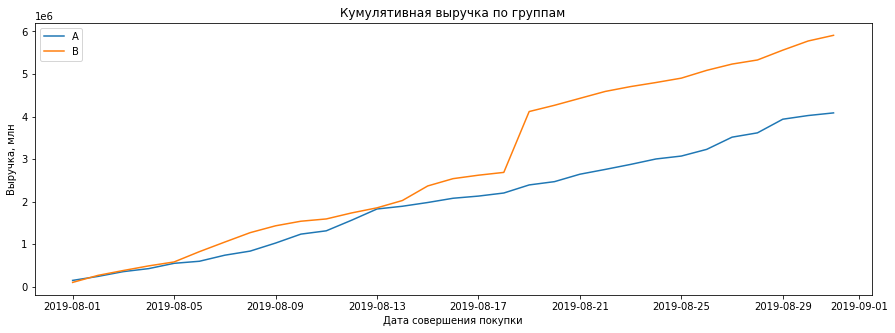

In [14]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(15,5))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend() 
plt.title('Кумулятивная выручка по группам')
plt.ylabel("Выручка, млн")
plt.xlabel("Дата совершения покупки")

None

**Промежуточный вывод:** Кумулятивная выручка в обеих группах увеличивается в течение всего исследуемого периода. В сегменте А она увеличивается линейно, в то время как сегмент В в середине теста (2019-08-18) заметно вырос и лидирует весь остаток теста. Это может быть обусловлено всплесками числа заказов или появлением аномально дорогих заказов в выборке. 

### 2.3 Построение графика кумулятивного среднего чека по группам

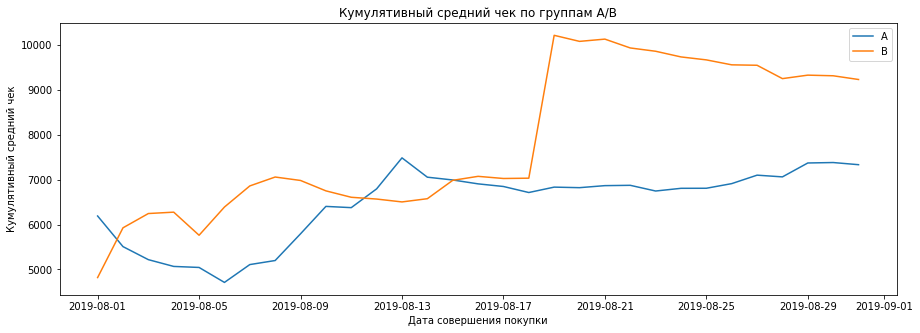

In [15]:
# Строим графики среднего чека по группам — делим кумулятивную выручку на кумулятивное число заказов
plt.figure(figsize=(15,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.legend() 
plt.title('Кумулятивный средний чек по группам А/В')
plt.ylabel('Кумулятивный средний чек')
plt.xlabel("Дата совершения покупки")

None

**Промежуточный вывод:** Кумулятивное значение среднего чека сегмента А на старте теста снижается, после 2019-08-06 начинает восстанавливаться и, достигнув пика 2019-08-13, постепенно стабилизируется примерно на одном уровне до конца теста. Кумулятивное значение среднего чека сегмента В на протяжении практически всего теста превышало значения сегмента А, при этом 2019-08-18 отмечен резкий скачок его значения (что вероятно вызвано крупными заказами), после чего наблюдается некоторое плавное снижение показателя. 

### 2.4 Построение графика относительного изменения кумулятивного среднего чека группы B к группе A

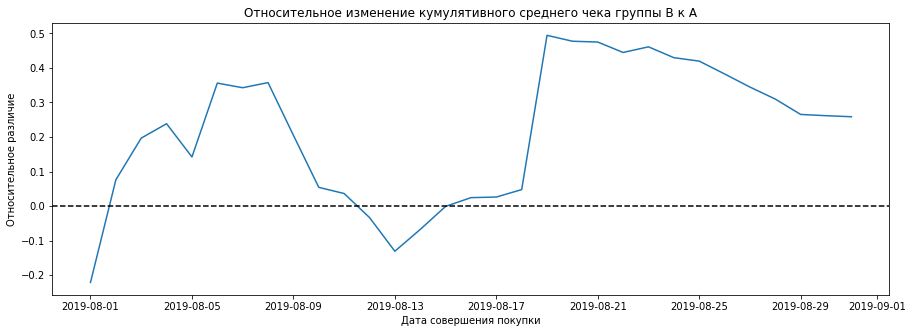

In [16]:
# Собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.\
merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15,5))

# Строим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])\
         /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# Добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 

plt.title('Относительное изменение кумулятивного среднего чека группы B к А')
plt.xlabel("Дата совершения покупки")
plt.ylabel("Относительное различие") 

None

**Промежуточный вывод:** График значительно и резко менялся в несколько дат. Видимо, именно тогда имели место аномальные заказы

### 2.5 Построение графика кумулятивного среднего количества заказов на посетителя по группам

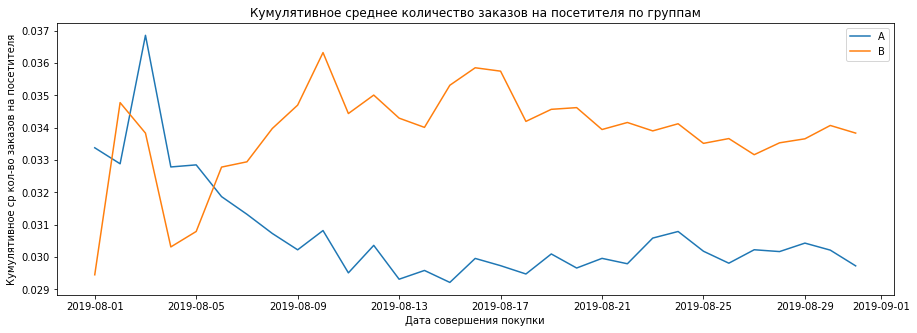

In [17]:
# Считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# Отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# Отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(15,5))

# Строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('Кумулятивное среднее количество заказов на посетителя по группам')
plt.xlabel("Дата совершения покупки")
plt.ylabel('Кумулятивное ср кол-во заказов на посетителя')
plt.legend()

None

**Промежуточный вывод:** В начале теста оба сегмента имели схожую динамику: рост с последующим снижением, однако в дальнейшем кумулятивное среднее количество заказов на посетителя сегмента А продолжило снижаться, в то время как этот же показатель сегмента В вырвалась вперед и продемонстрировала рост с некоторым последующем снижением, но все же заметно более высоким значением, чем сегмент А к концу срока проведения теста

### 2.6 Построение графика относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

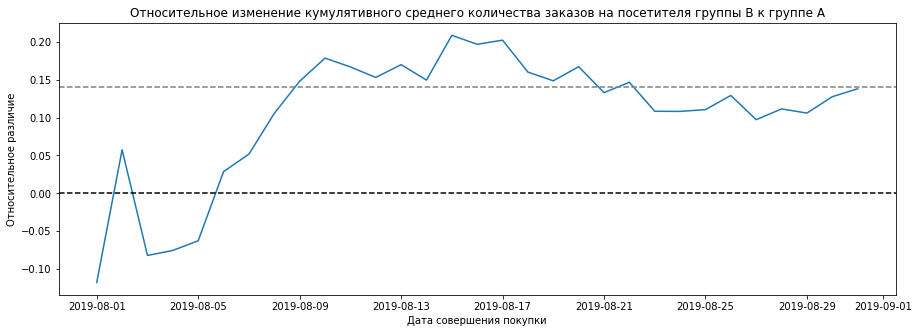

In [18]:
# Собираем данные в одном датафрейме
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15,5))

# Строим отношение 
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")

# Добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.14, color='grey', linestyle='--')

plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel("Дата совершения покупки")
plt.ylabel("Относительное различие") 

None 

**Промежуточный вывод:**  Относительное изменение кумулятивного среднего количества заказов на посетителя группы В к группе А почти с самого начала теста стабильно в пользу группы В и к концу теста фиксируется на уровне 14%

В целом графики кумулятивных метрик дают основания полагать, что  вероятнее всего в группе В есть аномально большие заказы, определяющие значительный прирост среднего чека

### 2.7 Построение точечного графика количества заказов по пользователям

In [19]:
# Расчитываем количество заказов по пользователям
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

# Присваиваем столбцам столбцам новые названия
orders_by_users.columns = ['user_id', 'orders']

# Сортируем по количеству заказов
orders_by_users.sort_values(by='orders', ascending=False).head(10)

,user_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


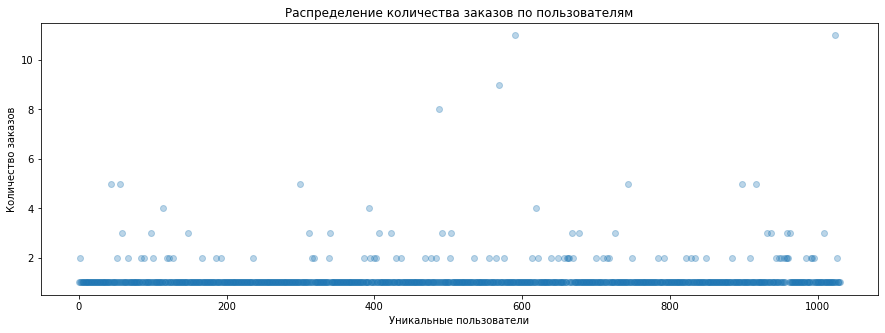

In [20]:
# Строим точечную диаграмму
x_values = pd.Series(range(0,len(orders_by_users)))
plt.figure(figsize=(15,5))
plt.scatter(x_values, orders_by_users['orders'], alpha=0.3) 
plt.title('Распределение количества заказов по пользователям')
plt.xlabel("Дата совершения покупки")
plt.xlabel("Уникальные пользователи")
plt.ylabel("Количество заказов")

None

**Промежуточный вывод:** Большинство пользователей сделали 1-2 заказа. Заказавших более двух раз довольно мало, однако необходимо расчитать выборочные перцентили для определения границы отсечения аномальных пользователей.

### 2.8 Расчет 95-го и 99-го перцентиля количества заказов на пользователя

In [21]:
np.percentile(orders_by_users['orders'], [95, 99])

array([2., 4.])

**Промежуточный вывод:** 5% пользователей совершают больше 2 покупок, и только 1% - более 4. Разумно выбрать 2 заказа на одного пользователя в качестве верхней границы числа заказов и отсеять по ней аномальных пользователей 

### 2.9 Построение точечного графика стоимостей заказов

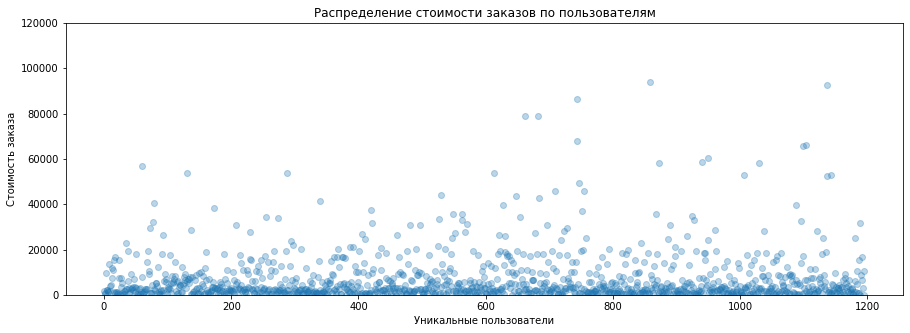

In [22]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(15,5))
plt.ylim(0, 120000)
plt.scatter(x_values, orders['revenue'], alpha=0.3)
plt.title('Распределение стоимости заказов по пользователям')
plt.xlabel("Уникальные пользователи")
plt.ylabel("Стоимость заказа")

None

**Промежуточный вывод:** Стоимость основной массы заказов не превышает 20000 руб, однако более точные границы аномалий позволит определить расчет перцентилей

### 2.10 Расчет 95-го и 99-го перцентиля стоимости заказов

In [23]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

**Промежуточный вывод:** Стоимость 95% заказов ниже 28000 рублей, а 99% случаев она не превышает 58233 рублей. Определяем границу по величине 99-го перцентиля 

### 2.11 Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Проверяем гипотезу. 

H0 = Различий в среднем количестве заказов между группами нет \
H1 = Различия в среднем количестве заказов между группами есть

In [24]:
# Подготавливаем данные
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5)) 

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              24           148579              21   
1 2019-08-02              20            93822              24   
2 2019-08-03              24           112473              16   
3 2019-08-04              16            70825              17   
4 2019-08-05              25           124218              23   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0           101217                  24               148579   
1           165531                  44               242401   
2           114248                  68               354874   
3           108571                  84               425699   
4            92428                 109               549917   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  21               101217               719   
1                  45               266748               619   
2                  61               38

Названия столбцов данных в объединенной таблице:
- date — дата
- ordersPerDateA — количество заказов в выбранную дату в группе A
- revenuePerDateA — суммарная выручка в выбранную дату в группе A
- ordersPerDateB — количество заказов в выбранную дату в группе B
- revenuePerDateB — суммарная выручка в выбранную дату в группе B
- ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A
- revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A
- ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B
- revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B
- visitorsPerDateA — количество пользователей в выбранную дату в группе A
- visitorsPerDateB — количество пользователей в выбранную дату в группе B
- visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A
- visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B

In [25]:
# Создаем переменные ordersByUsersA и ordersByUsersB со столбцами ['visitor_id', 'orders'] 
# укажем число заказов для пользователей, совершивших покупку хотя бы 1 раз
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 

# Объявляем переменные sampleA и sampleB, где пользователям из разных групп соответствует количество заказов
# Пользователям без закзавов соответствуют нули

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# Применяем критерий и выводим относительный прирост среднего числа заказов группы B

print("P-value:{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("Относительный прирост среднего числа заказов группы B: {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))


P-value:0.017
Относительный прирост среднего числа заказов группы B: 0.138


p-value меньше 0.05, поэтому нулевую гипотезу отвергаем. Анализ "сырых данных" сообщает, что в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего числа заказов группы B к группе А составляет 13,8%

### 2.12 Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным

Проверяем гипотезу. 

H0 = Различий в среднем чеке между группами нет \
H1 = Различия в среднем чеке между группами есть

In [26]:
# Передаем критерию mannwhitneyu() данные о выручке
print('P-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], \
                                                   orders[orders['group']=='B']['revenue'])[1]))

# Выводим относительные различия в среднем чеке между группами
print('Относительный прирост в среднем чеке заказов группы B относительно группы А: {0:.3f}'\
      .format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

P-value: 0.729
Относительный прирост в среднем чеке заказов группы B относительно группы А: 0.259


p-value значительно больше 0.05, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. При этом средний чек группы В значительно превышает средний чек группы А - на 25.9%

### 2.13 Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Проверяем гипотезу

H0 = Различий в среднем количестве заказов между группами нет \
H1 = Различия в среднем количестве заказов между группами есть


In [27]:
# Принимаем за аномальных пользователей с более чем 2 покупками и заказами дороже 58233. 
# Делаем соответствующие срезы

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 58233]['visitor_id']

# Объединяем таблицы
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))

# Выводим общее количество аномальных пользователей
print(abnormalUsers.shape[0])

1099    148427295
18      199603092
23      237748145
37      249864742
68      457167155
dtype: int64
31


In [28]:
# Считаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным
# Готовим выборки количества заказов по пользователям по группам теста без аномальных пользователей

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

In [29]:
# Применяем статистический критерий Манна-Уитни к полученным выборкам
print('P-value: {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительный прирост среднего числа заказов группы B: {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

P-value: 0.010
Относительный прирост среднего числа заказов группы B: 0.174


Обнаружен 31 аномальный пользователь. 

Анализ "очищенных данных" дает основания полагать, что в среднем количестве заказов между группами есть статистически значимые различия, поскольку p-value меньше 0.05. Соответственно, нулевую гипотезу отвергаем. Относительный прирост среднего числа заказов группы B к группе А составляет 17,4%. Сегмент В значительно лучше сегмента А 

### 2.14 Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным

Проверяем гипотезу.

H0 = Различий в среднем чеке между группами нет \
H1 = Различия в среднем чеке между группами есть

In [30]:
print(
    'P-value: {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Относительный прирост в среднем чеке заказов группы B относительно группы А: {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

P-value: 0.798
Относительный прирост в среднем чеке заказов группы B относительно группы А: -0.020


P-value незначительно увеличился и остается значительно больше 0.05, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. При этом средний чек группы А превысил чек группы В на 2%, в то время как по "сырым" данным средний чек группы В  был выше на 25.9%

### 2.15 Решение по результатам теста

Проведенное А/В тестирование выявило:

- Наличие статистически значимых различий в среднем количестве заказов на посетителя между группами как по «сырым», так и по «очищенным» данным. Относительный прирост среднего числа заказов группы B к группе А составляет 13,8% по «сырым данным» и 17,4% по «очищенным»

- Отсутствие статистически значимых различий в среднем чеке по «сырым» и «очищенным» данным. При этом стоит отметить, что по «очищенным» данным средний чек группы А превысил чек группы В на 2%, в то время как по "сырым" данным средний чек группы В  был выше на 25.9% из-за наличия аномально высоких значений в данных

Рекомендуется остановить тест и зафиксировать успех группы B (более высокое среднее количество заказов на посетителя по сравнению с группой А при равенстве средних чеков)


## 3 Общий вывод

**Цель исследования**

Цель настоящего исследования – проведение приоритизации гипотез для увеличения выручки и запуск А/В теста. 

**Качество данных и их предобработка**

Ранжирование 9 гипотез по приотритетности проводилось на основе одного датафрейма с заданными параметрами для исследования. Качество данных высокое: отсутствуют пропуски, корректно определен тип данных, однако потребовалось приведение названий столбцов к нижнему регистру
Для проведения А/В тестирования использовались два датафрейма, содержащих информацию о заказах (1197 записей) и пользователях сайта (62 записи). Данные не содержали пропуски и дубликаты и потребовали минимальной предобработки: преобразование формата столбцов с датой и временем и приведение ряда столбцов к нижнему регистру и snake_case

**Часть 1. Приоритизация гипотез**

Ранжирование по степени приоритетности с помощью фреймворка ICE 
-  Запустить акцию, дающую скидку на товар в день рождения
-  Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

Для учета охвата аудитории проведено ранжирование по степени приоритетности с помощью фреймворка RICE 
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей


**Часть 2. Анализ А/В теста**

- Кумулятивная выручка растет в течение всего исследуемого периода в обеих группах. В сегменте А она увеличивается линейно, в то время как в сегменте В отмечается скачок в середине теста (2019-08-18) с дальнейшим сохранением лидерства 
- Кумулятивное значение среднего чека сегмента В на протяжении практически всего теста превышало значения сегмента А. 2019-08-18 отмечен резкий скачок его значения, после чего наблюдается некоторое плавное снижение показателя с сохранением лидерства над показателями группы А. Кумулятивное значение среднего чека сегмента А на старте теста снижается, после 2019-08-06 начинает восстанавливаться и, достигнув пика 2019-08-13, постепенно стабилизируется примерно на одном уровне (ниже значений группы В) до конца теста. График относительного изменения кумулятивного среднего чека группы B к А демонстрирует ряд резких скачков, вызванных аномальными заказами
-  Кумулятивное среднее количество заказов на посетителя по группам демонстрировало схожую динамику на старте тестирования: рост с последующим снижением, однако в дальнейшем этот показатель сегмента А продолжил снижаться, в то время как сегмент В вырвался вперед.  На конец проведения теста относительный прирост среднего числа заказов группы B к группе А составляет 13,8%.
- Аномальными признаны пользователи совершившие более 2-х покупок (5% пользователей совершают больше 2 покупок, и только 1% - более 4) или на сумму более 58233 руб (стоимость 95% заказов ниже 28000 руб, а 99% случаев она не превышает 58233 руб). Количество аномальных пользователей - 31
- При проведении А/В теста было установлено наличие статистически значимых различий в среднем количестве заказов на посетителя между группами как по «сырым», так и по «очищенным» данным. Относительный прирост среднего числа заказов группы B к группе А составил 13,8% по «сырым данным» и 17,4% по «очищенным»
- Зафиксировано отсутствие статистически значимых различий в среднем чеке по «сырым» и «очищенным» данным. При этом по «очищенным» данным средний чек группы А превысил чек группы В на 2%, в то время как по "сырым" данным средний чек группы В был выше на 25.9% из-за наличия аномально высоких значений в данных
- Тест рекомендовано завершить с однозначной победой группы В благодаря более высокому среднему количеству заказов на посетителя по сравнению с группой А при равенстве средних чеков
